# Finite difference solver for T and C

Our particle growth calculations can yield solid growth rates
along the trajectory and we can relate this to the production of
heat and oxygen from crystal growth as a function of height above
the ICB. Here we seek to treat these as source terms in a finite
difference solution for the relaxed temperature (and oxygen content)
with defined boundary conditions at the top and bottom of the F-layer.
The idea is that we can then proceed as follows:

1. Pick an initial $T(R)$ and $C(R)$.
2. Solve the IVP for all the falling particles.
3. Calculate the heat and oxygen production rates, 
$Q(R)$ and $J(R)$.
4. Find $T(R)$ and $C(R)$ consistent with these source 
terms and the boundary conditions
5. Put these new functions into 2 and iterate.
6. When converged we have a solution that gives the fluxes out of the 
layer and everything we already calculate which includes latent heat
(which may push us towards equilibrium.

We end up with two iterative solutions (inside 4, and the 2 - 5 loop).
My guess is that 4 is fast compared to 2 - 5, which is why we converge
this at each step rather than take a single FD iteration inside the
outer loop.

This notebook outlines the development of the FD diffusion solver
in a way that is decoupled from the rest of the code. Note that the
same solver can be used for the two systems (just exchanging chemical 
and thermal diffusivity and choosing different boundary conditions and
source terms) and these can be treated separately unless we want to 
couple e.g. thermal conduction and oxygen content of the melt (which
seems excessive).

In [1]:
# Imports and system setup
import numpy as np
import scipy.integrate as spi
import scipy.interpolate as spinterp

import matplotlib.pyplot as plt
%matplotlib inline

r_icb = 1221.5e3
f_layer_thickness = 200.0e3



For our spherical geometry we need to solve:

$$\frac{1}{R^2}\frac{\mathrm{d}}{\mathrm{d} R}\left(\kappa R^2 \frac{\mathrm{d} T(R)}{\mathrm{d} R} \right) = Q(R) $$

where $\kappa$ is the thermal diffusivity and $Q(R)$ is some specified function
of heat production. We need to write this second order ODE as a system of two first order equations. First expanded as:

$$\kappa R^2 \frac{\mathrm{d}^2 T}{\mathrm{d} R^2} + 2 \kappa R \frac{\mathrm{d} T}{\mathrm{d} R} - R^2 Q(R) = 0$$

Then substitute $y_0 = T$ and $y_1 = \frac{\mathrm{d} T}{\mathrm{d} R}$ so that
$y_0^{\prime} = y_1$ and $y_1^{\prime} = \frac{\mathrm{d}^2 T}{\mathrm{d} R^2}$. Then:

$$\kappa R^2 y_1^{\prime} + 2 \kappa R y_1 - R^2 Q(R) = 0$$

We can then express our system of equations as:

$$y_0^{\prime} = y_1$$

$$y_1^{\prime} = \frac{(R^2 Q(R) - 2 \kappa R y_1)}{\kappa R^2}$$

And assuming I have this right, we can stuff this into a BVP solver
binding $Q(R)$ to our points. (I'm using $y_0$ and $y_1$, rather than 1
and 2, to match python's index notation.)

We also need boundary conditions. At the top I think these should be fixed
temperature (and composition) leaving the heat (and chemical) flux out of 
the layer as part of the solution. I note that these could be used to couple
the slurry layer with a thermal evolution model of the core.

At the bottom things are less clear. If the core is only growing by sedimentation,
maybe the correct boundary condition is zero flux?

Anyway, we can set this up as input to SciPy's BVP solver.

In [2]:
def solve_diffusion(rs, init_guess, sources, diffusivity, topbc):

    # Linear interpolator for sources
    source_fun = spinterp.interp1d(rs, sources, fill_value=0.0)
    
    def fun(x, y):
        sources = 0.0
        dy0_by_dx = y[1]
        dy1_by_dx = (x**2 * source_fun(x) - 2.0 * 
                     diffusivity * x * y[1]
                    ) / (diffusivity * x**2)
        
        return np.vstack((dy0_by_dx, dy1_by_dx))
                     
    def bc(ya, yb):
        return np.array([ya[1], yb[0] - topbc])
    
    result = spi.solve_bvp(fun, bc, rs, init_guess)
    
    return result

def plot_diffusion_solution(rs, init_guess, sources, diffusivity, topbc, res):
    
    fig, axs = plt.subplots(ncols=3, figsize=(12,4))
    r_plot = np.linspace(rs[0], rs[-1], num=500)
    t_plot = res.sol(r_plot)[0]
    dt_dr_plot = res.sol(r_plot)[1]
    axs[0].plot(r_plot/1000.0, t_plot)
    axs[1].plot(r_plot/1000.0, dt_dr_plot)
    
    axs[0].plot(rs/1000.0, init_guess[0], '--') 
    axs[1].plot(rs/1000.0, init_guess[1], '--')
    
    axs[1].plot(rs[0]/1000.0, 0.0, 'o')
    axs[0].plot(rs[-1]/1000.0, topbc, 'o')
    
    axs[2].plot(rs/1000, sources)
    
    axs[0].set_xlabel('$R$ (km)')
    axs[0].set_ylabel('$T(R)$ (K)')
    axs[1].set_xlabel('$R$ (km)')
    axs[1].set_ylabel('$\mathrm{d}T / \mathrm{d}R$ (K)')
    axs[2].set_xlabel('$R$ (km)')
    axs[2].set_ylabel('$Q(R)$ (??)')
    
    fig.tight_layout()
    plt.show()

## Test case 1

This is something like we may expect. Heat sources distributed evenly 
in the layer (but zero on the boundaries). Try with a uniform initial guess
at the temperature (matching the boundary condition at the top) and thus zero derivative (matching the boundary condition at the bottom). Gradient needs to let
all the heat conduct out of the top so it gets colder downwards.

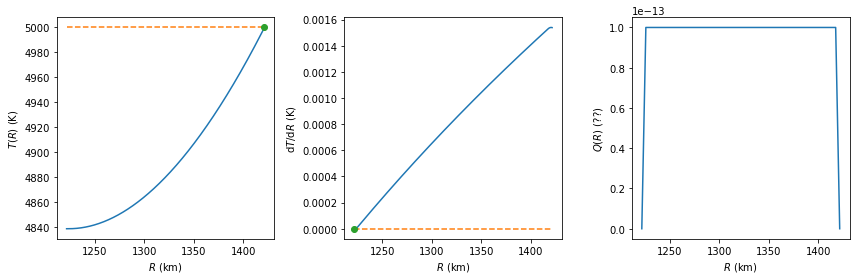

In [3]:
r = np.linspace(r_icb, r_icb+f_layer_thickness, num=50)

k     = 100.0                    # thermal conductivity of solid iron 
rhos  = 12700                    # solid density
rhol  = 12100                    # liquid density
cp    = 750                      # specific heat
kappa = k/(rhol*cp)


heat_sources = np.ones_like(r) * 1.0E-13 # J m^-3 s^-1?
heat_sources[0] = 0.0
heat_sources[-1] = 0.0


t_top = 5000.0
initial_t = np.ones_like(r) * t_top
initial_dtdr = np.zeros_like(r)

res = solve_diffusion(r, np.vstack((initial_t, initial_dtdr)), 
                                   heat_sources, kappa, t_top)

plot_diffusion_solution(r, np.vstack((initial_t, initial_dtdr)), 
                                   heat_sources, kappa, t_top, res)

## Test case 2

Something approximating no slurry, put all heat sources on the lower boundary. 
Keep the  uniform initial guess at the temperature (matching the boundary condition at the top) and thus zero derivative (matching the boundary condition at the bottom). I'll keep the total heat production rate fixed.

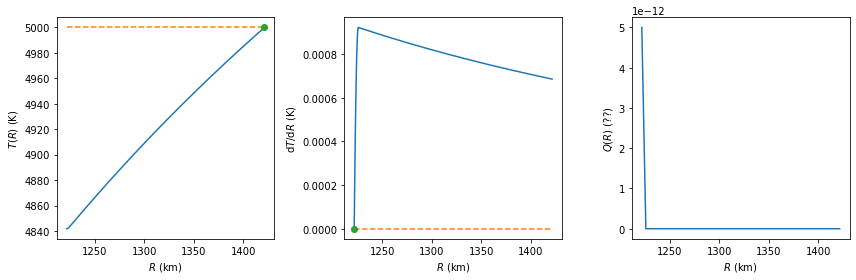

In [4]:
r = np.linspace(r_icb, r_icb+f_layer_thickness, num=50)

k     = 100.0                    # thermal conductivity of solid iron 
rhos  = 12700                    # solid density
rhol  = 12100                    # liquid density
cp    = 750                      # specific heat
kappa = k/(rhol*cp)


heat_sources = np.zeros_like(r) 
heat_sources[0] = r.size * 1.0E-13 # J m^-3 s^-1?
heat_sources[-1] = 0.0


t_top = 5000.0
initial_t = np.ones_like(r) * t_top
initial_dtdr = np.zeros_like(r)

res = solve_diffusion(r, np.vstack((initial_t, initial_dtdr)), 
                                   heat_sources, kappa, t_top)

plot_diffusion_solution(r, np.vstack((initial_t, initial_dtdr)), 
                                   heat_sources, kappa, t_top, res)

## Test case 3

What if we put all the heat sources in the middle of the layer?

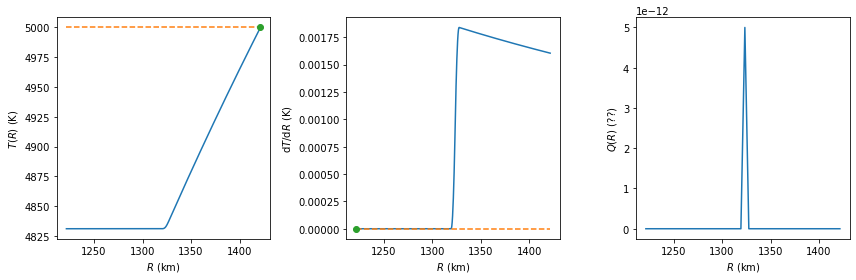

In [5]:
r = np.linspace(r_icb, r_icb+f_layer_thickness, num=50)

k     = 100.0                    # thermal conductivity of solid iron 
rhos  = 12700                    # solid density
rhol  = 12100                    # liquid density
cp    = 750                      # specific heat
kappa = k/(rhol*cp)


heat_sources = np.zeros_like(r) 
heat_sources[25] = r.size * 1.0E-13 # J m^-3 s^-1?
heat_sources[-1] = 0.0


t_top = 5000.0
initial_t = np.ones_like(r) * t_top
initial_dtdr = np.zeros_like(r)

res = solve_diffusion(r, np.vstack((initial_t, initial_dtdr)), 
                                   heat_sources, kappa, t_top)

plot_diffusion_solution(r, np.vstack((initial_t, initial_dtdr)), 
                                   heat_sources, kappa, t_top, res)